#MIT 6.036 Spring 2019: Homework 7#

This colab notebook provides code and a framework for problem 2 of [the homework](https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week7/week7_homework/).  You can work out your solutions here, then submit your results back on the homework page when ready.

## <section>**Setup**</section>

First, download the code distribution for this homework that contains test cases and helper functions.

Run the next code block to download and import the code for this lab.


In [16]:
from code_for_hw7 import *
import numpy as np
import modules_disp as disp

# 2) Implementing Neural Networks

This homework considers neural networks with multiple layers. Each layer has multiple inputs and outputs, and can be broken down into two parts:

<br>
A linear module that implements a linear transformation:     $ z_j = (\sum^{m}_{i=1} x_i W_{i,j}) + {W_0}_jz$

specified by a weight matrix $W$ and a bias vector $W_0$. The output is $[z_1, \ldots, z_n]^T$

<br>
An activation module that applies an activation function to the outputs of the linear module for some activation function $f$, such as Tanh or ReLU in the hidden layers or Softmax (see below) at the output layer. We write the output as: $[f(z_1), \ldots, f(z_m)]^T$, although technically, for some activation functions such as softmax, each output will depend on all the $z_i$.

We'll use the modular implementation that we guided you through in the previous problem, which leads to clean code. The basic framework for SGD training is given below. We can construct a network and train it as follows:

```
# build a 3-layer network
net = Sequential([Linear(2,3), Tanh(),
                  Linear(3,3), Tanh(),
    	          Linear(3,2), SoftMax()])
# train the network on data and labels
net.sgd(X, Y)
```
Please fill in any unimplemented methods below:

## Linear Modules: ##
Each linear module has a forward method that takes in a batch of activations A (from the previous layer) and returns a batch of pre-activations Z.

Each linear module has a backward method that takes in dLdZ and returns dLdA. This module also computes and stores dLdW and dLdW0, the gradients with respect to the weights.

In [17]:
class Linear(Module):
    def __init__(self, m, n):
        self.m, self.n = (m, n)  # (in size, out size)
        self.W0 = np.zeros([self.n, 1])  # (n x 1)
        self.W = np.random.normal(0, 1.0 * m ** (-.5), [m, n])  # (m x n)

    def forward(self, A):
        self.A = A   # (m x b)  Hint: make sure you understand what b stands for
        return  np.dot(self.W.T, A) + self.W0  # Your code (n x b)

    def backward(self, dLdZ):  # dLdZ is (n x b), uses stored self.A
        self.dLdW =  np.dot(self.A,dLdZ.T)     # Your code
        self.dLdW0 = dLdZ.sum(axis=1).reshape((self.n, 1))      # Your code
        return np.dot(self.W, dLdZ) # Your code: return dLdA (m x b)

    def sgd_step(self, lrate):  # Gradient descent step
        self.W =  self.W - lrate*self.dLdW   # Your code
        self.W0 = self.W0 - lrate*self.dLdW0          # Your code

 You are encouraged to make your own tests for each module. A unit test method and an example test case are given below for your reference:

In [18]:
np.random.seed(0)

# data
X, Y = super_simple_separable()

# module
linear_1 = Linear(2, 3)

#hyperparameters
lrate = 0.005

# test case
# forward
z_1 = linear_1.forward(X)
exp_z_1 =  np.array([[10.41750064, 6.91122168, 20.73366505, 22.8912344],
                     [7.16872235, 3.48998746, 10.46996239, 9.9982611],
                     [-2.07105455, 0.69413716, 2.08241149, 4.84966811]])
unit_test("linear_forward", exp_z_1, z_1)

# backward
dL_dz1 = np.array([[1.69467553e-09, -1.33530535e-06, 0.00000000e+00, -0.00000000e+00],
                                     [-5.24547376e-07, 5.82459519e-04, -3.84805202e-10, 1.47943038e-09],
                                     [-3.47063705e-02, 2.55611604e-01, -1.83538094e-02, 1.11838432e-04]])
exp_dLdX = np.array([[-2.40194628e-02, 1.77064845e-01, -1.27021626e-02, 7.74006953e-05],
                                    [2.39827939e-02, -1.75870737e-01, 1.26832126e-02, -7.72828555e-05]])
dLdX = linear_1.backward(dL_dz1)
unit_test("linear_backward", exp_dLdX, dLdX)

# sgd step
linear_1.sgd_step(lrate)
exp_linear_1_W = np.array([[1.2473734,  0.28294514,  0.68940437],
                           [1.58455079, 1.32055711, -0.69218045]]),
unit_test("linear_sgd_step_W",  exp_linear_1_W,  linear_1.W)

exp_linear_1_W0 = np.array([[6.66805339e-09],
                            [-2.90968033e-06],
                            [-1.01331631e-03]]),
unit_test("linear_sgd_step_W0", exp_linear_1_W0, linear_1.W0)


linear_forward: OK
linear_backward: OK
linear_sgd_step_W: OK
linear_sgd_step_W0: OK


The following datasets are defined for your use:
*  `super_simple_separable_through_origin()`
*  `super_simple_separable()`
*  `xor()`
*  `xor_more()`
*  `hard()`

Further, a plotting function is defined for your usage in modules_disp.py, and can be called in the colab notebook as `disp.plot_nn()`.
```
def plot_nn(X, Y, nn):
    """ Plot output of nn vs. data """
    def predict(x):
        return nn.modules[-1].class_fun(nn.forward(x))[0]
    xmin, ymin = np.min(X, axis=1)-1
    xmax, ymax = np.max(X, axis=1)+1
    nax = plot_objective_2d(lambda x: predict(x), xmin, xmax, ymin, ymax)
    plot_data(X, Y, nax)
    plt.show()```


## Activation functions: ##
Each activation module has a forward method that takes in a batch of pre-activations Z and returns a batch of activations A.

Each activation module has a backward method that takes in dLdA and returns dLdZ, with the exception of SoftMax, where we assume dLdZ is passed in.

### Tanh: ###

In [19]:
class Tanh(Module):            # Layer activation
    def forward(self, Z):
        self.A = np.tanh(Z)
        return self.A

    def backward(self, dLdA):    # Uses stored self.A
        return dLdA * (1 - self.A ** 2)              # Your code: return dLdZ (?, b)

### ReLU: ###

In [20]:
class ReLU(Module):              # Layer activation
    def forward(self, Z):
        self.A = np.maximum(0,Z)            # Your code: (?, b)
        return self.A

    def backward(self, dLdA):    # uses stored self.A
        return dLdA * (self.A != 0)           # Your code: return dLdZ (?, b)

### SoftMax: ###
For `SoftMax.class_fun()`, given the column vector of class probabilities for each point (computed by Softmax), return a vector of the classes (integers) with the highest probability for each point.

In [21]:
class SoftMax(Module):           # Output activation
    def forward(self, Z):
        return np.exp(Z) / np.sum(np.exp(Z), axis=0)
    
    def backward(self, dLdZ):    # Assume that dLdZ is passed in
        return dLdZ

    def class_fun(self, Ypred):  # Return class indices
        return np.argmax(Ypred, axis=0)              # Your code: (1, b)

## Loss Functions:##
Each loss module has a forward method that takes in a batch of predictions Ypred (from the previous layer) and labels Y and returns a scalar loss value.

The NLL module has a backward method that returns dLdZ, the gradient with respect to the preactivation to SoftMax (note: not the activation!), since we are always pairing SoftMax activation with NLL loss

### NLL: ###

In [22]:
class NLL(Module):       # Loss
    def forward(self, Ypred, Y):
        self.Ypred = Ypred
        self.Y = Y
        return   float(np.sum(-Y * np.log(Ypred)))    # Your code

    def backward(self):  # Use stored self.Ypred, self.Y
        return self.Ypred - self.Y       # Your code

## Activation and Loss Test Cases: ##
Run Test 1 and Test 2 below and compare your outputs with the expected outputs.


In [23]:
# TEST 1: sgd_test for Tanh activation and SoftMax output
np.random.seed(0)
sgd_test(Sequential([Linear(2,3), Tanh(), Linear(3,2), SoftMax()], NLL()), test_1_values)

linear_1.W: OK
linear_1.W0: OK
linear_2.W: OK
linear_2.W0: OK
z_1: OK
a_1: OK
z_2: OK
a_2: OK
loss: OK
dloss: OK
dL_dz2: OK
dL_da1: OK
dL_dz1: OK
dL_dX: OK
updated_linear_1.W: OK
updated_linear_1.W0: OK
updated_linear_2.W: OK
updated_linear_2.W0: OK


In [24]:
# TEST 2: sgd_test for ReLU activation and SoftMax output
np.random.seed(0)
sgd_test(Sequential([Linear(2,3), ReLU(), Linear(3,2), SoftMax()], NLL()), test_2_values)

linear_1.W: OK
linear_1.W0: OK
linear_2.W: OK
linear_2.W0: OK
z_1: OK
a_1: OK
z_2: OK
a_2: OK
loss: OK
dloss: OK
dL_dz2: OK
dL_da1: OK
dL_dz1: OK
dL_dX: OK
updated_linear_1.W: OK
updated_linear_1.W0: OK
updated_linear_2.W: OK
updated_linear_2.W0: OK


## Neural Network: ##

Implement SGD. Randomly pick a data point Xt, Yt by using np.random.randint to choose a random index into the data. Compute the predicted output Ypred for Xt with the forward method. Compute the loss for Ypred relative to Yt. Use the backward method to compute the gradients. Use the sgd_step method to change the weights. Repeat.

We will (later) be generalizing SGD to operate on a "mini-batch" of data points instead of a single point. You should strive for an implementation of the forward, backward, and `class_fun` methods that works with batches of data. Note that when $b$ is mentioned as part of the shape of a matrix in the code, this $b$ refers to the number of points.

In [39]:
 class Sequential:
    def __init__(self, modules, loss):            # List of modules, loss module
        self.modules = modules
        self.loss = loss

    def sgd(self, X, Y, iters=100, lrate=0.005):  # Train
        D, N = X.shape
        for it in range(iters):
            i = np.random.randint(N)
            Xt = X[:, i:i+1]                                  # Your code
            Yt = Y[:, i:i+1]                                  # Your code
            Ypred = self.forward(Xt)
            sum_loss = self.loss.forward(Ypred, Yt)
            err = self.loss.backward()
            self.backward(err)
            self.sgd_step(lrate)
            
    def forward(self, Xt):                        # Compute Ypred
        for m in self.modules: Xt = m.forward(Xt)
        return Xt

    def backward(self, delta):                    # Update dLdW and dLdW0
        # Note reversed list of modules
        for m in self.modules[::-1]: delta = m.backward(delta)

    def sgd_step(self, lrate):                    # Gradient descent step
        for m in self.modules: m.sgd_step(lrate)

    def print_accuracy(self, it, X, Y, cur_loss, every=250):
        # Utility method to print accuracy on full dataset, should
        # improve over time when doing SGD. Also prints current loss,
        # which should decrease over time. Call this on each iteration
        # of SGD!
        if it % every == 1:
            cf = self.modules[-1].class_fun
            acc = np.mean(cf(self.forward(X)) == cf(Y))
            print('Iteration =', it, '\tAcc =', acc, '\tLoss =', cur_loss, flush=True)

## Neural Network / SGD Test Cases: ##
Use Test 3 and Test 4 to help you debug.

-3.46493986 -3.41956036 3.39710997 2.0597278


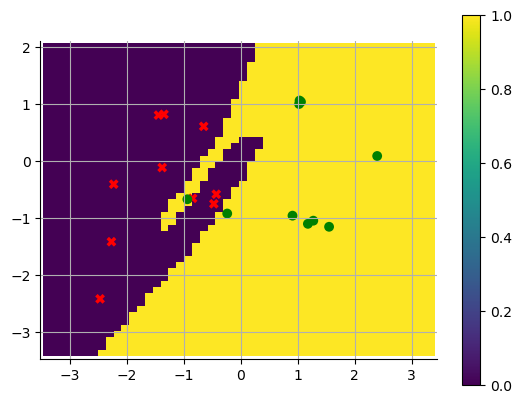

In [51]:
# TEST 3: you should achieve 100% accuracy on the hard dataset (note that we provided plotting code)
X, Y = hard()
nn = Sequential([Linear(2, 10), ReLU(), Linear(10, 10), ReLU(), Linear(10,2), SoftMax()], NLL())
disp.classify(X, Y, nn, it=100000)



In [33]:
# TEST 4: try calling these methods that train with a simple dataset
def nn_tanh_test():
    np.random.seed(0)
    nn = Sequential([Linear(2, 3), Tanh(), Linear(3, 2), SoftMax()], NLL())
    X, Y = super_simple_separable()
    nn.sgd(X, Y, iters=1, lrate=0.005)
    return [np.vstack([nn.modules[0].W, nn.modules[0].W0.T]).tolist(),
            np.vstack([nn.modules[2].W, nn.modules[2].W0.T]).tolist()]


def nn_relu_test():
    np.random.seed(0)
    nn = Sequential([Linear(2, 3), ReLU(), Linear(3, 2), SoftMax()], NLL())
    X, Y = super_simple_separable()
    nn.sgd(X, Y, iters=2, lrate=0.005)
    return [np.vstack([nn.modules[0].W, nn.modules[0].W0.T]).tolist(),
            np.vstack([nn.modules[2].W, nn.modules[2].W0.T]).tolist()]


def nn_pred_test():
    np.random.seed(0)
    nn = Sequential([Linear(2, 3), ReLU(), Linear(3, 2), SoftMax()], NLL())
    X, Y = super_simple_separable()
    nn.sgd(X, Y, iters=1, lrate=0.005)
    Ypred = nn.forward(X)
    return nn.modules[-1].class_fun(Ypred).tolist(), [nn.loss.forward(Ypred, Y)]


In [34]:
nn_tanh_test()

# Expected output:
# '''
# [[[1.2473733761848262, 0.2829538808226157, 0.6924193292712828],
#   [1.5845507770278007, 1.320562932207846, -0.6901721567010647],
#   [-8.47337764291184e-12, 2.6227368810847106e-09, 0.00017353185263155828]],
#  [[0.544808855557535, -0.08366117689965663],
#   [-0.06331837550937104, 0.24078409926389266],
#   [0.08677202043839037, 0.8360167748667923],
#   [-0.0037249480614718, 0.0037249480614718]]]
# '''

[[[1.2473733761848262, 0.2829538808226157, 0.6924193292712828],
  [1.5845507770278007, 1.320562932207846, -0.6901721567010647],
  [-8.47337764291184e-12, 2.6227368810847102e-09, 0.00017353185263155828]],
 [[0.544808855557535, -0.08366117689965663],
  [-0.06331837550937103, 0.24078409926389266],
  [0.08677202043839037, 0.8360167748667923],
  [-0.0037249480614717995, 0.0037249480614718]]]

In [35]:
nn_relu_test()

# Expected output:
# '''
# [[[1.2421914999646917, 0.2851239946607419, 0.6905003767490479],
#   [1.5695659964519526, 1.3273884281993562, -0.6920877418422037],
#   [-0.0027754917572235106, 0.001212351486908601, -0.0005239629389906042]],
#  [[0.501769700845158, -0.040622022187279644],
#   [-0.09260786974986723, 0.27007359350438886],
#   [0.08364438851530624, 0.8391444067898763],
#   [-0.004252310922204504, 0.004252310922204505]]]
# '''

[[[1.2421914999646917, 0.2851239946607419, 0.6905003767490479],
  [1.5695659964519526, 1.3273884281993562, -0.6920877418422037],
  [-0.002775491757223511, 0.001212351486908601, -0.0005239629389906042]],
 [[0.501769700845158, -0.04062202218727964],
  [-0.09260786974986725, 0.27007359350438886],
  [0.08364438851530624, 0.8391444067898763],
  [-0.004252310922204505, 0.004252310922204505]]]

In [36]:
nn_pred_test()

# Expected output:
# '''
# ([0, 0, 0, 0], [8.56575061835767])
# '''

([0, 0, 0, 0], [8.565750618357672])